In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
import matplotlib.pyplot as plt
import dataset
from model import ResNet18YOLOv1
from loss import YOLOv1Loss
from tqdm import tqdm

# About
This is an implementation of YOLOv1 from ***You Only Look Once: Unified, Real-Time Object Detection by Joseph Redmon, Santosh Divvala, Ross Girshick, and Ali Firhadi.*** Object detection is figuring out what objects are in an image and where they are. Another way to look at this problem is how can we write a computer program that draws bounding boxes around objects and predicts what kind of objects they are. YOLO solves this problem and does it super fast, like state of the art fast!

Let's talk about R-CNN, the predecessor to YOLO. It proposed regions, ran a classifier on every region, and did some post-processing to produce the final result. In simple language this translates to:
1. Lemme draw a lot of bounding boxes where I think objects are
2. Lemme figure out what are in the bounding boxes I drew
3. Ok, I drew too many bounding boxes, lemme remove most of them and keep the important ones

This is a lot of steps. What YOLO does instead is ***unified detection***. Unified detection combines the different components of object detection (where are the objects and what kind of objects are they) into one Convolutional Neural Network. You give it an image and in one swoop, it tells you exactly that.

Here's how it does it:
1. Divide the image into a SxS grid
2. Each cell in the grid predicts B bounding boxes and C class probabilities (what it thinks the object is)

We represent bounding boxes with 5 numbers: x, y, w, h, p.
- (x, y): center of the bounding box
- w: width
- h: height
- p: confidence (a measure of how confident we are that this box captures an object and matches the ground truth)

Accordingly, YOLOv1 produces a SxSx(5B+C) tensor. Each cell predicts B bounding boxes, how do we choose which one is the "true" predictor? How do we measure how good our bounding box and classification predictions are? 

We check which bounding box has the greatest overlap (IOU: Intersection Over Union) with the ground truth and choose that one as a predictor. We use this loss function to measure the "goodness" of our predictions:

![yolo loss function](https://i.stack.imgur.com/IddFu.png)

On a high level, it is the squared error between our prediction and the ground truth. 

# PASCAL VOC 2007 Dataset

PASCAL VOC Detection Dataset contains annotated images with 20 labelled classes and bounding boxes. There are 2,501 images in the training set, 2,510 images in the validation set, and 4,952 images in the test set.

In [27]:
# original dataset
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

pascal_voc_val = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="val",
    download=False
)

pascal_voc_test = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="test",
    download=False
)

In [28]:
# augment dataset for YOLOv1: resize and normalize image and convert bounding boxes from annotations to tensors
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)
voc_val = dataset.PascalVOC(pascal_voc=pascal_voc_val)
voc_test = dataset.PascalVOC(pascal_voc=pascal_voc_test)

TRANSFORMING PASCAL VOC
TRANSFORMING PASCAL VOC
TRANSFORMING PASCAL VOC


In [29]:
BATCH_SIZE = 64

In [30]:
# train_dataloader = DataLoader(voc_train, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(voc_val, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(voc_test, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader = DataLoader(voc_train, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(voc_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(voc_test, batch_size=BATCH_SIZE, shuffle=False)

# Training

## Device

In [31]:
DEVICE = "cpu"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")

DEVICE

device(type='cuda')

## Hyperparameters
- S: dimensions of SxS grid
- B: number of bounding boxes predicted per cell
- C: number of classes

In [32]:
S = 7
B = 2
C = 20
lambda_coord = 5.0
lambda_noobj = 0.5

## Model
ResNet18 convolutional layers pretrained on ImageNet with 2 feedforward layers outputting a (N x S x S x (5B + C)) tensor.

In [33]:
yolo = ResNet18YOLOv1(S=S, B=B, C=C).to(DEVICE)

## Loss + Optimizer
![yolo loss function](https://i.stack.imgur.com/IddFu.png)

We use stochastic gradient descent with a learning rate of 1e-3, weight decay (L2 regularization) of 0.0005, and momentum of 0.9.

In [34]:
yolo_loss = YOLOv1Loss(S=S, B=B, C=C, lambda_coord=lambda_coord, lambda_noobj=lambda_noobj)

## Train
Train model with a learning rate of 1e-3 for the first few epochs, raise learning rate to 1e-2 and train for 75 epochs, then lower to 1e-3 for 30 epochs, and finally 1e-4 for 30 epochs.

We train the network for about 135 epochs.

In [35]:
def evaluate_loss(model, criterion, dataloader):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)

            pred = model(X)
            loss = criterion(pred, Y)
            total_loss += loss.item()
            
    N = len(dataloader)
    # loss = total_loss / N
    loss = total_loss
    
    return loss

In [36]:
torch.cuda.empty_cache()

In [37]:
EPOCHS = 135
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

def train_yolo(model, criterion, train_dataloader, val_dataloader):
    pre_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
    scheduler = MultiStepLR(optimizer,
                            milestones=[75, 105],
                            gamma=0.1)
    
    train_losses = []
    val_losses = []

    N = len(train_dataloader)

    # train
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        lr = optimizer.param_groups[0]["lr"]
        for i, (X, Y) in enumerate(tqdm(train_dataloader, leave=False, desc=f"Epoch [{epoch+1}/{EPOCHS}]: lr={lr}")):
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)

            pred = model(X)
            
            # print(pred)
            loss = criterion(pred, Y)
            # print(loss)
            total_loss += loss.item()

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = total_loss / N
        train_losses.append(train_loss)

        # update learning rate
        scheduler.step()

        # evaluate on validation set
        val_loss = evaluate_loss(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss={train_loss}, Val Loss={val_loss}")
    
    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_yolo(yolo,
           yolo_loss,
           train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

Epoch [1/135]: Train Loss=13.076026654243469, Val Loss=8.242039775848388


Epoch [2/135]: Train Loss=7.555111837387085, Val Loss=7.0126620650291445


Epoch [3/135]: Train Loss=6.330504268407822, Val Loss=6.748044264316559


Epoch [4/135]: Train Loss=5.602589225769043, Val Loss=6.502433907985687


Epoch [5/135]: Train Loss=5.095652854442596, Val Loss=6.412951004505158


Epoch [6/135]: Train Loss=4.541189247369767, Val Loss=6.240354895591736


Epoch [7/135]: Train Loss=4.177050065994263, Val Loss=6.16488698720932


Epoch [8/135]: Train Loss=3.935801684856415, Val Loss=6.179985439777374


Epoch [9/135]: Train Loss=3.634955132007599, Val Loss=6.083581030368805


Epoch [10/135]: Train Loss=3.278478467464447, Val Loss=6.008610856533051


Epoch [11/135]: Train Loss=3.0551515400409697, Val Loss=5.977478551864624


Epoch [12/135]: Train Loss=2.8305365204811097, Val Loss=5.963375318050384


Epoch [13/135]: lr=0.001:  42%|████▎     | 17/40 [00:13<00:18,  1.24it/s]

Epoch [25/135]: Train Loss=1.2844058126211166, Val Loss=5.891993165016174


Epoch [26/135]: Train Loss=1.2400614470243454, Val Loss=5.86917667388916


NameError: name 'train' is not defined

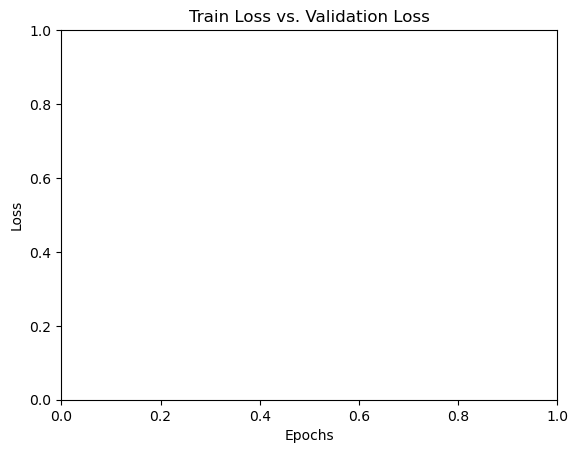

In [23]:
plt.title("Train Loss vs. Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(range(EPOCHS), train_losses, label="Train Loss")
plt.plot(range(EPOCHS), val_losses, label="Val Loss")

plt.legend()

In [ ]:
_l